In [1]:
# Import libraries
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora, models, utils
from gensim.models import LdaModel
from gensim import similarities
from gensim.models.phrases import Phrases, Phraser

import re
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords, wordnet
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
from cleantext import clean

from wordcloud import WordCloud
import seaborn as sns

Since the GPL-licensed package `unidecode` is not installed, using Python's `unicodedata` package which yields worse results.


In [2]:
cv_data = pd.read_csv('../data/cv_data.csv' ,encoding='utf-8')
cv_data.head()

,category,resume
0,Data Science,Skills Programming Languages Python pandas num...
1,Data Science,Education Details May 2013 to May 2017 B E UIT...
2,Data Science,Areas of Interest Deep Learning Control System...
3,Data Science,Skills R Python SAP HANA Tableau SAP HANA SQL ...
4,Data Science,Education Details MCA YMCAUST Faridabad Haryan...


In [3]:
def preprocess_text(text):
    # Tokenize text
    tokens = text.lower().split()
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    
    # Lemmatize words
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    return tokens

In [4]:
# Preprocess resumes
preprocessed_cv = cv_data['resume'].apply(preprocess_text)

In [5]:
# Create dictionary representation of resumes
dictionary = corpora.Dictionary(preprocessed_cv)

In [6]:
# Load LDA model
lda_model = models.LdaModel.load("../model/lda_model_ds")

In [7]:
# Create document-term matrix using the loaded dictionary
doc_term_matrix = [lda_model.id2word.doc2bow(desc) for desc in preprocessed_cv]

In [8]:
# Infer topics for resumes using the loaded LDA model
topics = [lda_model.get_document_topics(doc) for doc in doc_term_matrix]

In [9]:
# Print the inferred topics for each resume in the new dataset
for doc_topics in topics:
    for topic, prob in doc_topics:
        print(f"Topic: {topic} | Probability: {prob}")
    print()

Topic: 0 | Probability: 0.21858225762844086
Topic: 1 | Probability: 0.21243979036808014
Topic: 2 | Probability: 0.01979161612689495
Topic: 3 | Probability: 0.03288351744413376
Topic: 5 | Probability: 0.12194604426622391
Topic: 7 | Probability: 0.06583651900291443
Topic: 8 | Probability: 0.3278939723968506

Topic: 0 | Probability: 0.5489672422409058
Topic: 2 | Probability: 0.09955217689275742
Topic: 3 | Probability: 0.020012062042951584
Topic: 5 | Probability: 0.21234145760536194
Topic: 7 | Probability: 0.0852772444486618
Topic: 9 | Probability: 0.030325589701533318

Topic: 0 | Probability: 0.2811616361141205
Topic: 1 | Probability: 0.17940150201320648
Topic: 2 | Probability: 0.04904446750879288
Topic: 3 | Probability: 0.03178894519805908
Topic: 5 | Probability: 0.0874439924955368
Topic: 8 | Probability: 0.09280741959810257
Topic: 9 | Probability: 0.2766118049621582

Topic: 0 | Probability: 0.038789596408605576
Topic: 1 | Probability: 0.40638554096221924
Topic: 3 | Probability: 0.059980

In [10]:
# Extract topic probabilities and consolidate in the CV dataset
for i, doc_topics in enumerate(topics):
    topic_probs = [0.0] * lda_model.num_topics
    for topic, prob in doc_topics:
        topic_probs[topic] = prob
    for j, prob in enumerate(topic_probs):
        cv_data.loc[i, f"Topic_{j} Probability"] = prob

cv_data.head()

,category,resume,Topic_0 Probability,Topic_1 Probability,Topic_2 Probability,Topic_3 Probability,Topic_4 Probability,Topic_5 Probability,Topic_6 Probability,Topic_7 Probability,Topic_8 Probability,Topic_9 Probability
0,Data Science,Skills Programming Languages Python pandas num...,0.218582,0.212440,0.019792,0.032884,0.000000,0.121946,0.0,0.065837,0.327894,0.000000
1,Data Science,Education Details May 2013 to May 2017 B E UIT...,0.548967,0.000000,0.099552,0.020012,0.000000,0.212341,0.0,0.085277,0.000000,0.030326
2,Data Science,Areas of Interest Deep Learning Control System...,0.281162,0.179402,0.049044,0.031789,0.000000,0.087444,0.0,0.000000,0.092807,0.276612
3,Data Science,Skills R Python SAP HANA Tableau SAP HANA SQL ...,0.038790,0.406386,0.000000,0.059981,0.054916,0.053446,0.0,0.048230,0.319745,0.011752
4,Data Science,Education Details MCA YMCAUST Faridabad Haryan...,0.031931,0.543139,0.203391,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.208164


In [11]:
# Calculate the average probability for each resume across all topics
cv_data['Qualification Score'] = cv_data[[f"Topic_{j} Probability" for j in range(lda_model.num_topics)]].mean(axis=1)

cv_data.head()

,category,resume,Topic_0 Probability,Topic_1 Probability,Topic_2 Probability,Topic_3 Probability,Topic_4 Probability,Topic_5 Probability,Topic_6 Probability,Topic_7 Probability,Topic_8 Probability,Topic_9 Probability,Qualification Score
0,Data Science,Skills Programming Languages Python pandas num...,0.218582,0.212440,0.019792,0.032884,0.000000,0.121946,0.0,0.065837,0.327894,0.000000,0.099937
1,Data Science,Education Details May 2013 to May 2017 B E UIT...,0.548967,0.000000,0.099552,0.020012,0.000000,0.212341,0.0,0.085277,0.000000,0.030326,0.099648
2,Data Science,Areas of Interest Deep Learning Control System...,0.281162,0.179402,0.049044,0.031789,0.000000,0.087444,0.0,0.000000,0.092807,0.276612,0.099826
3,Data Science,Skills R Python SAP HANA Tableau SAP HANA SQL ...,0.038790,0.406386,0.000000,0.059981,0.054916,0.053446,0.0,0.048230,0.319745,0.011752,0.099325
4,Data Science,Education Details MCA YMCAUST Faridabad Haryan...,0.031931,0.543139,0.203391,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.208164,0.098662


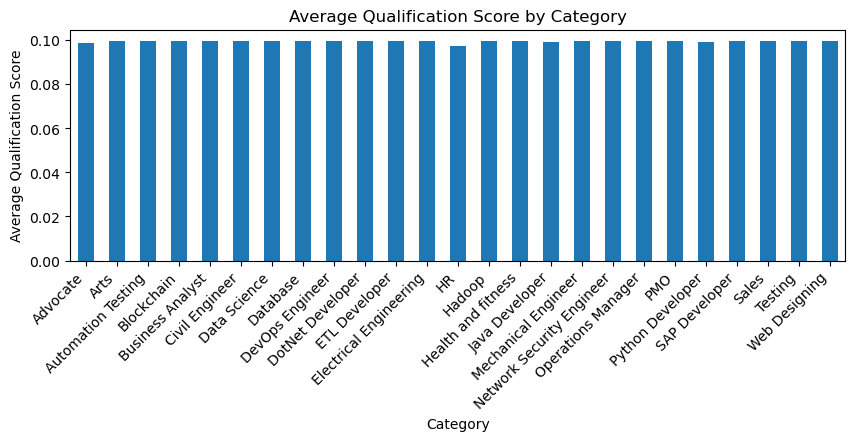

In [12]:
# Calculate the average qualification score for each category
average_scores = cv_data.groupby('category')['Qualification Score'].mean()

# Plot a bar chart of the average scores
plt.figure(figsize=(10, 3))
ax = average_scores.plot(kind='bar')
ax.set_xlabel('Category')
ax.set_ylabel('Average Qualification Score')
ax.set_title('Average Qualification Score by Category')
ax.set_xticklabels(average_scores.index, rotation=45, ha='right')
plt.show()


### Cosine similarity score

In [13]:
#Import data files
jd_ds = pd.read_csv("../data/jd_ds.csv",encoding='utf-8')
jd_ds.head()

,description
0,ABOUT HOPPER At Hopper we re on a mission to m...
1,At Noom we use scientifically proven methods t...
2,Decode M Data Science Manager Job Description ...
3,Sapphire Digital seeks a dynamic and driven mi...
4,Director Data Science 200537 Description Edelm...


In [14]:
def preprocess_text(text):
    # Tokenize text
    tokens = text.lower().split()
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    
    # Lemmatize words
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    return tokens

In [15]:
# Preprocess job descriptions
preprocessed_job_description = jd_ds['description'].apply(preprocess_text)

In [16]:
# Create a TfidfVectorizer
vectorizer = TfidfVectorizer()

In [17]:
# Fit and transform the job description
job_description_vector = vectorizer.fit_transform([' '.join(preprocessed_job_description[0])])

# Calculate cosine similarity between each resume and the job description
similarity_scores = []
for preprocessed_resume in preprocessed_cv:
    resume_vector = vectorizer.transform([' '.join(preprocessed_resume)])
    similarity_score = cosine_similarity(resume_vector, job_description_vector)[0][0]
    similarity_scores.append(similarity_score)


In [18]:
# Add similarity scores to the CV dataset
cv_data['Similarity Score'] = similarity_scores
cv_data.head()

,category,resume,Topic_0 Probability,Topic_1 Probability,Topic_2 Probability,Topic_3 Probability,Topic_4 Probability,Topic_5 Probability,Topic_6 Probability,Topic_7 Probability,Topic_8 Probability,Topic_9 Probability,Qualification Score,Similarity Score
0,Data Science,Skills Programming Languages Python pandas num...,0.218582,0.212440,0.019792,0.032884,0.000000,0.121946,0.0,0.065837,0.327894,0.000000,0.099937,0.543689
1,Data Science,Education Details May 2013 to May 2017 B E UIT...,0.548967,0.000000,0.099552,0.020012,0.000000,0.212341,0.0,0.085277,0.000000,0.030326,0.099648,0.274985
2,Data Science,Areas of Interest Deep Learning Control System...,0.281162,0.179402,0.049044,0.031789,0.000000,0.087444,0.0,0.000000,0.092807,0.276612,0.099826,0.312528
3,Data Science,Skills R Python SAP HANA Tableau SAP HANA SQL ...,0.038790,0.406386,0.000000,0.059981,0.054916,0.053446,0.0,0.048230,0.319745,0.011752,0.099325,0.497581
4,Data Science,Education Details MCA YMCAUST Faridabad Haryan...,0.031931,0.543139,0.203391,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.208164,0.098662,0.267845


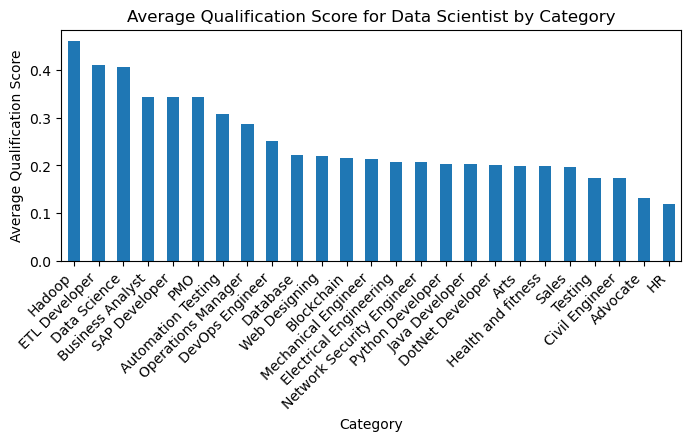

In [22]:
# Calculate the average qualification score for each category
average_scores = cv_data.groupby('category')['Similarity Score'].mean()

# Sort the average scores in descending order
ds_average_scores_sorted = average_scores.sort_values(ascending=False)

# Plot a bar chart of the sorted average scores
plt.figure(figsize=(8, 3))
ax = ds_average_scores_sorted.plot(kind='bar')
ax.set_xlabel('Category')
ax.set_ylabel('Average Qualification Score')
ax.set_title('Average Qualification Score for Data Scientist by Category')
ax.set_xticklabels(ds_average_scores_sorted.index, rotation=45, ha='right')

plt.show()


In [20]:
average_scores.sort_values(ascending=False)

category
Hadoop                       0.461964
ETL Developer                0.410098
Data Science                 0.405642
Business Analyst             0.344496
SAP Developer                0.343161
PMO                          0.342636
Automation Testing           0.306847
Operations Manager           0.286208
DevOps Engineer              0.250518
Database                     0.221344
Web Designing                0.219385
Blockchain                   0.216117
Mechanical Engineer          0.213156
Electrical Engineering       0.206331
Network Security Engineer    0.206023
Python Developer             0.203780
Java Developer               0.203142
DotNet Developer             0.199750
Arts                         0.199158
Health and fitness           0.197798
Sales                        0.195784
Testing                      0.174042
Civil Engineer               0.173929
Advocate                     0.131355
HR                           0.118322
Name: Similarity Score, dtype: float64